# Clip Tiles to County Boundary for Bulk Download

This notebook contains steps to clip the tile index - dem, aerial, point cloud - to an area of interest (AOI) boundary.
- Acquire the Tile Index Layer of interest
 - DEM
 - Aerial
 - Point Cloud
- Bring in your AOI
    - shapefile
    - GeoJson
    - Rest End Point
    - other format
- Spatial Analysis
- Export
    - List to work with locally
    - download files directly from S3

In [1]:
# # Install modules if necessary
# %pip install boto3
# %pip install botocore
# %pip install geopandas
# %pip install matplotlib

## Get Tile Index

Within the examples folder is the [*constants.py*](constants.py), which I use for some variable declaration (eg., tile package links).

Or

Use Tile Index Geopackage link from the [README](../README.md#) or from [KyFromAbove Open Data Explorer](https://kyfromabove.s3.us-west-2.amazonaws.com/index.html).  Just navigate to the appropriate Aerial or Elevation Folder.<br>
<br><center>
<img src="../media/aws_explorer.jpg" width="600" height="200">
</center><br>

Once you navigate to the Geopackage Folder, you can right click on the Geopackage you need and copy the link.

In [2]:
# import modules
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import geopandas as gpd
import matplotlib
from typing import Optional
import os

import constants  #  this brings in variable names to help save time

## Read in the tile index

For Pandas GeodataFrames, I will use the prefix **gdf_**.

The only thing you need to change would be the URL to the tile index layer and your AOI url/path.

In [3]:
# enter the url for title_url
# you can copy and paste from above
tile_url = constants.phase3orthos # brings in the variable name from constants

In [4]:
# read the tile_url into a geodataframe
gdf_tiles = gpd.read_file(tile_url)
gdf_tiles = gdf_tiles.to_crs(epsg=4326)
gdf_tiles.head(1)

/Users/ianhorn/Documents/AWS/examples-repo/kyfromabove-on-aws-examples/venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: unable to open database file: this file is a WAL-enabled database. It cannot be opened because it is presumably read-only or in a read-only directory. Retrying with IMMUTABLE=YES open option
  return ogr_read(


,tilename,key,aws_url,size,geometry
0,N038E388,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,https://kyfromabove.s3.us-west-2.amazonaws.com...,1017406604,"MULTIPOLYGON (((-82.94931 38.74231, -82.95107 ..."


In [5]:
# Plot the tiles, no need to add a map yet.
print(gdf_tiles.columns)
# gdf_tiles.plot()

Index(['tilename', 'key', 'aws_url', 'size', 'geometry'], dtype='object')


___
## Add an area of interest

This can be done by reading in a file locally or making a request.  For this example I leverage the KyFromAbove [Vector Services](https://kygisserver.ky.gov/arcgis) to query the [CountyShading](https://kygisserver.ky.gov/arcgis/rest/services/WGS84WM_Services/Ky_CountyShading_WGS84WM/MapServer) service for Fleming County. I clicked on the service, under layers click *County_Information (0)* to open up the layer  I will query.  Scroll to the bottom and click *query*.  

In the *Where* clause, use `1=1'` to get everything\*\*.  In *Out Fields*, enter _*_.  Switch the *Format* to `GeoJson`.  Press the `Query (Get)` button.  Copy the URL for the GeoJson.

_If you use chrome, the [Map-Services-Enhanced](https://github.com/raykendo/Map-Services-Enhanced) extension will let you copy a shortened url of your query._

\*_Note: If you have a geometry (Shapefile, GeoJson, GeoParquet, etc) file locally, you can substitute the `url` for your data file path. Geopandas can read many different formats._

\*\* _[ArcGIS Rest API Services](https://kygisserver.ky.gov/arcgis/sdk/rest/index.html#//02ss0000006v000000)_

In [6]:
# paste in the url from the rest endpoint query
aoi_url = 'https://kygisserver.ky.gov/arcgis/rest/services/WGS84WM_Services/Ky_CountyShading_WGS84WM/MapServer/0/query?where=1%3D1&units=esriSRUnit_Foot&outFields=*&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson'

# use gdf for geodatframe
gdf_aoi = gpd.read_file(aoi_url)
gdf_aoi.head(1)

,OBJECTID,NAME,FIPS_ID,NAME2,ADDNAME,SEAT,SEAT2,FORM_YR,PARENTCO,FIPS_NO,...,LAST_UPDT,XY_SOURCE,XY_ISSUES,ATT_SOURCE,ATT_ISSUES,COMMENTS,KYTC_District_Num,Shape.area,Shape.len,geometry
0,1,ADAIR,21001,Adair,LAKE CUMBERLAND,Columbia,COLUMBIA,1802,Green,1,...,741484800000,BOUNDARY DIGITIZED FROM USGS 7.5 MINUTE TOPOGR...,None,SECRETARY OF STATE,None,None,8,1.149684e+10,462429.34138,"POLYGON ((-85.16518 37.3104, -85.16992 37.3120..."


In [7]:
# print columns
gdf_aoi.columns

Index(['OBJECTID', 'NAME', 'FIPS_ID', 'NAME2', 'ADDNAME', 'SEAT', 'SEAT2',
       'FORM_YR', 'PARENTCO', 'FIPS_NO', 'FIPS_TXT', 'SMIS', 'SP_ZONE',
       'REGION', 'POP70', 'POP80', 'POP90', 'POP00', 'POP10', 'CH70_80',
       'CH80_90', 'CH90_00', 'CH00_10', 'POP70SQ', 'POP80SQ', 'POP90SQ',
       'POP00SQ', 'POP10SQ', 'CHSQ70_80', 'CHSQ80_90', 'CHSQ90_00',
       'CHSQ00_10', 'MILES_SQ', 'Forecast', 'ABBREVTN', 'ABBREVTN2',
       'AGENCY_CONT', 'CONTACT', 'LAST_UPDT', 'XY_SOURCE', 'XY_ISSUES',
       'ATT_SOURCE', 'ATT_ISSUES', 'COMMENTS', 'KYTC_District_Num',
       'Shape.area', 'Shape.len', 'geometry'],
      dtype='object')

      NAME2                                           geometry
34  Fleming  POLYGON ((-83.64186 38.52539, -83.72175 38.503...


<Axes: >

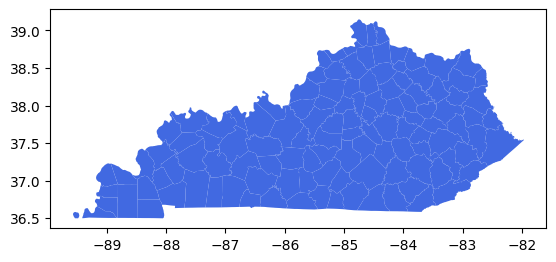

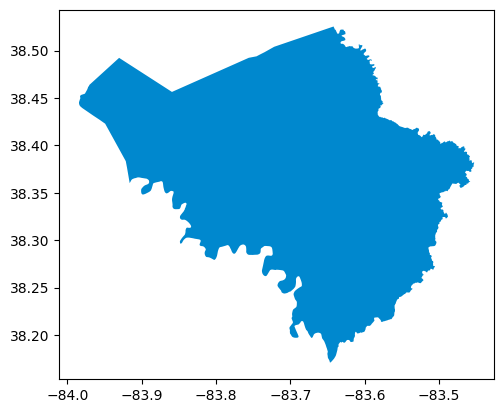

In [8]:
# clean up the dataframe a little bit
cols_to_keep = ['NAME2', 'geometry']
gdf_aoi = gdf_aoi[cols_to_keep]
gdf_aoi.plot(color='#4169E1')

# select for Fleming County
gdf_aoi = gdf_aoi[gdf_aoi["NAME2"] == "Fleming"]
print(gdf_aoi)
gdf_aoi.plot(color='#0088CE')

___

## Create a function to clip the tiles to the AOI

In [9]:
#### Create a function to clop the tiles to the AOI
def clip_tiles_to_aoi(gdf_tiles, gdf_aoi):
    # clip the tiles to the AOI
    gdf_tiles_clipped = gpd.clip(gdf_tiles, gdf_aoi)
    return gdf_tiles_clipped

#### Clip the tiles

In [10]:
gdf_tiles_clipped = clip_tiles_to_aoi(gdf_tiles, gdf_aoi)

# print the number of tiles
total_num_tiles = gdf_tiles_clipped.shape[0]

print(f'\nThe clipped tiles AOI has {total_num_tiles} tiles.\n')
gdf_tiles_clipped.head(1)


The clipped tiles AOI has 463 tiles.



,tilename,key,aws_url,size,geometry
2783,N063E331,imagery/orthos/Phase3/KY_KYAPED_2023_Season1_3...,https://kyfromabove.s3.us-west-2.amazonaws.com...,830894183,"POLYGON ((-83.95639 38.43217, -83.95652 38.426..."


<Axes: >

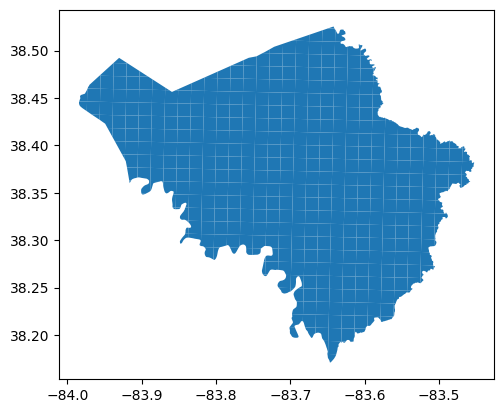

In [11]:
gdf_tiles_clipped.plot()

___
## Download tiles for AOI

Now that we've clipped the tile in our area of interest, now we want to download the files.  Here are some steps:
1. Setup boto3 for no-sign requests.
2. Choose an output location (local drive, your own AWS bucket, etc)
3. Define a function
4. Download

### Set up AWS

The bucket name is `kyfromabove`.  We just need to set that variable once.

When we set up the downloads, we need to use the `key` column from the clipped GeoDataFrame.

*Note: Refer to the Help Documentation to set up [File Transfer Configurations](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3.html)*

In [12]:
# set up the AWS Client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket = 'kyfromabove'

# print the key values 
print(gdf_tiles_clipped['key'].head(3))

2783     imagery/orthos/Phase3/KY_KYAPED_2023_Season1_3...
11188    imagery/orthos/Phase3/KY_KYAPED_2023_Season1_3...
5725     imagery/orthos/Phase3/KY_KYAPED_2023_Season1_3...
Name: key, dtype: object


### Create a function to download files

This will user Geopandas *.itertuples():* to iterate through the dataframe download the files.

If you want to be prompted to enter your output folder path, uncomment this the block below.  Otherwise, skip.

In [13]:
# # enter a download path
# download_path = input('enter your output folder path: ')

# print(download_path)

If you just want to enter your path for the variable, use this block below.  Otherwise comment out or skip

In [14]:
# enter a download path

download_path = '../downloads/tiles'  # enter your path in quotations

if not os.path.exists(download_path):
    os.makedirs(download_path)
    print(f'Folder created: {download_path}')
else:
    print(f'Folder already exist: {download_path}')


print(download_path)

Folder already exist: ../downloads/tiles
../downloads/tiles


This next block sets a creates function to with an optional limit on number of downloads.

In [15]:
# create a function to download the tiles
def download_tiles(s3, bucket, gdf_tiles_clipped, download_path, max_downloads: Optional[int]) -> None:  # Just downloading 5 for my example
    """
    Downloads COG or COPC files from an S3 bucket based on the input AOI GeoDataFrame.

    Args:
        s3: The S3 client used to access the bucket.
        bucket: The name of the S3 bucket to download from.
        gdf_tiles_clipped: A GeoDataFrame containing tile information (e.g., bounding boxes).
        download_path: The local directory path where the files should be saved.
        max_downloads: Optional limit on the number of tiles to download.
    
    Returns:
        None
    """
    
    downloaded_files = []  # creating a list of downloaded files
    try:
        for i, row in enumerate(gdf_tiles_clipped.itertuples()):
            if i >= max_downloads:
                break  # stop after max iterations
            
            key = row.key
            # get the base file name of the key
            file_name = key.split('/')[-1]
            local_file_path = os.path.join(download_path, file_name)
            # append to file list
            downloaded_files.append(file_name)
            
            # download file
            if not os.path.exists(local_file_path):  # this will skip downloading duplicates
                s3.download_file(bucket, key, local_file_path)
                print(f'Downloaded {file_name}')
    except Exception as e:
        print(f"Error occurred: {e}")


    return downloaded_files

#### Download files

In [16]:
# # Showing the variables we created.
# bucket = bucket
# s3 = s3
# gdf_tiles_clipped = gdf_tiles_clipped
# max_downloads = total_num_tiles


download = download_tiles(s3, bucket, gdf_tiles_clipped, download_path, max_downloads=total_num_tiles)

Downloaded N063E331_2023_Season1_3IN_cog.tif
Downloaded N062E331_2023_Season1_3IN_cog.tif
Downloaded N062E330_2023_Season1_3IN_cog.tif
Downloaded N061E331_2023_Season1_3IN_cog.tif
Downloaded N061E330_2023_Season1_3IN_cog.tif
Downloaded N060E331_2023_Season1_3IN_cog.tif
Downloaded N059E331_2023_Season1_3IN_cog.tif
Downloaded N075E357_2023_Season1_3IN_cog.tif
Downloaded N074E358_2023_Season1_3IN_cog.tif
Downloaded N074E357_2023_Season1_3IN_cog.tif
Downloaded N073E357_2023_Season1_3IN_cog.tif
Downloaded N072E358_2023_Season1_3IN_cog.tif
Downloaded N072E357_2023_Season1_3IN_cog.tif
Downloaded N071E358_2023_Season1_3IN_cog.tif
Downloaded N071E357_2023_Season1_3IN_cog.tif


Phase3 Orthoimagery Bulk Download of Fleming County, Kentucky.
<br><center><img src='https://raw.githubusercontent.com/ianhorn/kyfromabove-on-aws-examples/refs/heads/main/media/fleming.jpeg' width="500" height="400"></center>

___
## Create a raster or mosaic dataset in your GIS software of choice.